In [1]:
# HY-2B 60N以下swh


In [2]:
import pyproj
from  pyproj  import  CRS
from pyproj import Proj
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import pandas as pd

In [35]:
# 设置空间分辨率
resolution = 10000

# 将WGS 84坐标（4326）转化为等距圆柱投影（4088）
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS.from_epsg(4088)
crs2 = CRS.from_string("epsg:4088")
crs2 = CRS.from_proj4("+proj=latlon")
crs2 = CRS.from_user_input(4088)

transformer = pyproj.Transformer.from_crs(crs,crs2)
transformer_back = pyproj.Transformer.from_crs(crs2,crs)

In [36]:
# 获取数组的长和宽
def get_nlat_nlon_npaeqd(resolution):
    nlat, nlon =40000000/ resolution,40000000/ resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon
    
# 获取用来存放数据的grid数组，及其对应的grid_num数组（用来存放一个格子中有多少重合点）
def get_swh_grid(nlat, nlon):
    swh_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
    swh_grid_num = np.zeros((nlon,nlat))
    return swh_grid, swh_grid_num

# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
def  coincident_point_mean(value_array, grid_array, grid_num_array, projlats, projlons):
    for i in range(len(value_array)):
        x = int((projlons[i] )/resolution)
        y = int(projlats[i]/resolution)
        if grid_num_array[x][y] == 0:
            grid_array[x][y] = value_array[i]
            grid_num_array[x][y] += 1
        else:
            grid_array[x][y] += value_array[i]
            grid_num_array[x][y] += 1
    grid_array = grid_array / grid_num_array
    return grid_array

In [37]:
hy_dir_path = 'E:\python_workfile\\remote_sensing\H2B_nc_data\H2B_20200711'
hyfiles = glob.glob(hy_dir_path + '\*.nc')
hy_lon_array = np.array([])
hy_lat_array = np.array([])
hy_value_array = np.array([])
hy_swhc_mask_array = np.array([])
for hyfile in hyfiles:
    fh = Dataset(hyfile, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    swhc = fh.variables['swh_c'][:]
    swhc_mask = swhc.mask
    hy_lon_array = np.append(hy_lon_array, lons)
    hy_lat_array = np.append(hy_lat_array, lats)
    hy_value_array = np.append(hy_value_array, swhc)
    hy_swhc_mask_array = np.append(hy_swhc_mask_array, swhc_mask)
    fh.close()
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)


In [38]:
# 去除纬度在60度以上的点
index = []
for i in range(len(hy_value_array_masked)):
    if hy_lat_array[i] > 60:
        index.append(i)

hy_lat_array = np.delete(hy_lat_array, index)
hy_lon_array = np.delete(hy_lon_array, index)
hy_value_array = np.delete(hy_value_array, index)
hy_swhc_mask_array = np.delete(hy_swhc_mask_array, index)
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)

In [39]:
hy_projlats,hy_projlons = transformer.transform(hy_lat_array,hy_lon_array)


In [40]:
# 获取东西半球的nlat，nlon，hy_grid_west,hy_grid_num_west
hy_nlat, hy_nlon =get_nlat_nlon_npaeqd(resolution)
hy_grid, hy_grid_num = get_swh_grid(hy_nlat, hy_nlon)

# 交叉点平均化
hy_grid = coincident_point_mean(hy_value_array_masked, hy_grid, hy_grid_num, hy_projlats,hy_projlons)


<ipython-input-36-b084ab6424b3>:20: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-36-b084ab6424b3>:23: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


In [48]:
# 数据转换
n = np.int(20003989.28 / resolution /2)
temp = np.array(hy_grid[:n])
hy_grid[0:hy_grid.shape[0]-n] = hy_grid[n:]
hy_grid[hy_grid.shape[0]-n:] = temp

In [44]:
# 校准y坐标
hy_x = np.arange(hy_nlat)
hy_y = np.arange(hy_nlon) - np.int(hy_nlon / 2)
hy_xx , hy_yy = np.meshgrid(hy_x * resolution, hy_y * resolution)

# 将xx,yy转换回坐标形式
hy_y_map, hy_x_map = transformer_back.transform(hy_xx , hy_yy)




In [45]:

for i in range(hy_x_map.shape[0]):
    for j in range(hy_x_map.shape[1]):
        if hy_x_map[i][j]<0:
            hy_x_map[i][j] += 360

<ipython-input-49-18b7b41116a1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(hy_x_map, hy_y_map, hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)


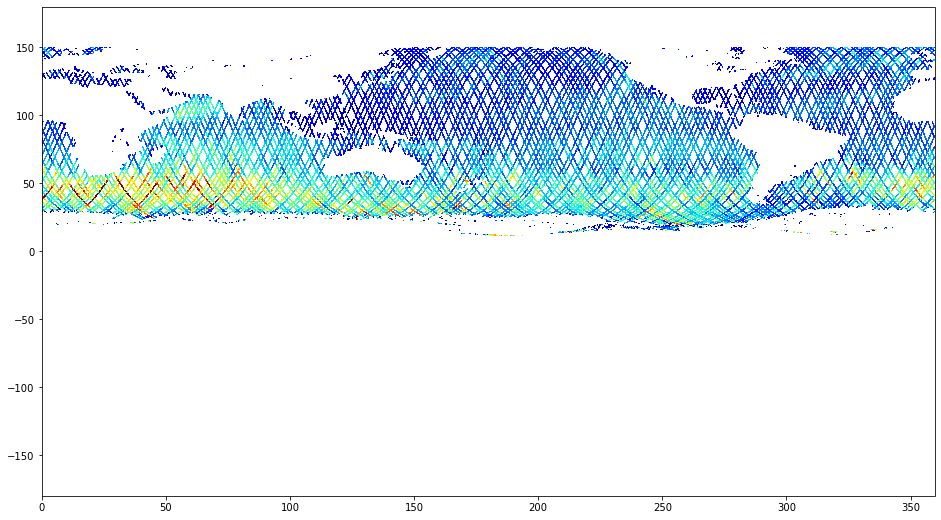

In [49]:
plt.figure(1,figsize=(16,9))
plt.pcolor(hy_x_map, hy_y_map, hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)
plt.show()

<ipython-input-46-87113273b14b>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)


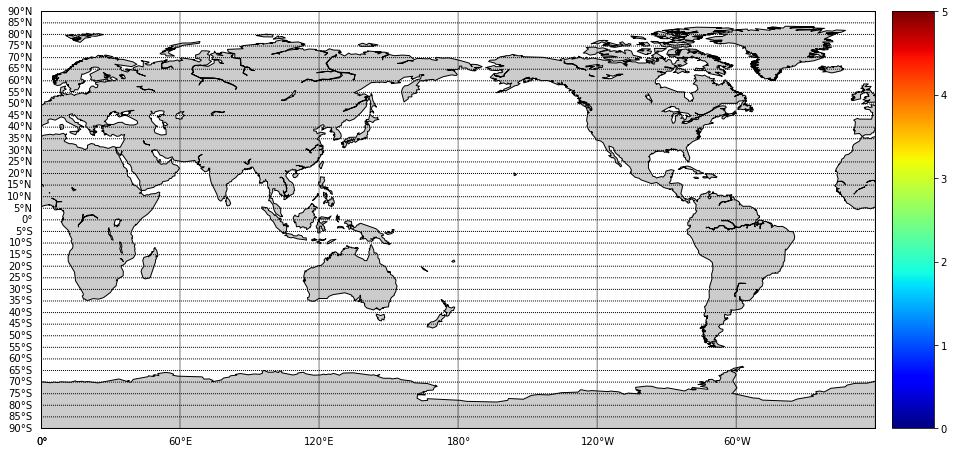

In [46]:
plt.figure(1,figsize=(16, 9))
hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')

hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)

h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
hy_m.colorbar(location='right')

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)
plt.close()

# 2.CYROSAT2 60度以下波高


In [43]:
cy_dir_path = 'F:\\remote_sensing_data\CRYOSAT-2\\20200701_20200711'
cyfiles = glob.glob(cy_dir_path + '\*.nc')
cy_lon_array = np.array([])
cy_lat_array = np.array([])
cy_swh_array = np.array([])
cy_swh_mask_array = np.array([])
for cyfile in cyfiles:
    with Dataset(cyfile, mode='r') as fh:
        lons = fh.variables['lon_01'][:]
        lats = fh.variables['lat_01'][:]
        swh = fh.variables['swh_ocean_01_ku'][:]
        swh_mask = swh.mask
        if np.array(swh_mask,dtype = bool).shape == ():
            swh_mask = np.full((len(swh), ), False)
        cy_lon_array = np.append(cy_lon_array, lons)
        cy_lat_array = np.append(cy_lat_array, lats)
        cy_swh_array = np.append(cy_swh_array, swh)
        cy_swh_mask_array = np.append(cy_swh_mask_array, swh_mask)
        
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)


KeyboardInterrupt: 

In [ ]:
cy_swh_array_masked.shape

In [ ]:
cy_lat_array.shape

In [ ]:
cy_projlats,cy_projlons = transformer.transform(cy_lat_array,cy_lon_array)

In [ ]:

cy_nlat, cy_nlon =get_nlat_nlon_npaeqd(resolution)
cy_grid, cy_grid_num = get_swh_grid(cy_nlat, cy_nlon)

# 交叉点平均化
cy_grid = coincident_point_mean(cy_swh_array_masked, cy_grid, cy_grid_num, cy_projlats,cy_projlons)
# cy_grid_west = coincident_point_mean(cy_swh_array_masked, cy_grid_west, cy_grid_num_west, cy_projlats_west, cy_projlons_west)

In [ ]:
# 校准y坐标
cy_x = np.arange(cy_nlat)
cy_y = np.arange(cy_nlon) - np.int(cy_nlon / 2)
cy_xx , cy_yy = np.meshgrid(cy_x * resolution, cy_y * resolution)

# 将xx,yy转换回坐标形式
cy_y_map, cy_x_map = transformer_back.transform(cy_xx , cy_yy)



In [ ]:
for i in range(cy_x_map.shape[1]):
    if cy_x_map[0,i] < 0 :
        cy_x_map[:,i] += 360


In [ ]:
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
plt.pcolor(cy_xi ,cy_yi, cy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)

In [ ]:
plt.figure(1,figsize=(16, 9))
cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)

cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)
plt.close()

In [ ]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = np.abs(hy_grid - cy_grid )
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)

In [ ]:
hy_overlap_swh = np.array([])
cy_overlap_swh = np.array([])
diff_value = np.array([])
for i in range(len(hy_cy_diff_grid)):
    hy_overlap_swh = np.append(hy_overlap_swh, hy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])
    cy_overlap_swh = np.append(cy_overlap_swh, cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])
    diff_value = np.append(diff_value, round(hy_cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]], 8))


In [ ]:
# 将每个交叉点的数值记入DataFrame

hy_cy_data={'HY-2B swh':hy_overlap_swh,
      'CRYOSAT swh':cy_overlap_swh,
      'Diff':diff_value
     }
hy_cy_df = pd.DataFrame(hy_cy_data)





In [ ]:
hy_cy_df

In [ ]:
print(hy_cy_df['Diff'].mean(), hy_cy_df['Diff'].var(), hy_cy_df['Diff'].std())

In [ ]:
hy_cy_df['HY-2B swh'].mean()

In [ ]:
hy_cy_df['CRYOSAT swh'].mean()

In [ ]:
hy_cy_df['Diff'].mean()